In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import Polygon
from SyntheticControlMethods import Synth
from PIL import Image

In [2]:
Image.MAX_IMAGE_PIXELS = None

In [3]:
def rebin(a, shape):
    '''
    Resizes a numpy array to the desired shape.
    '''
    sh = shape[0], a.shape[0]//shape[0], shape[1], a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)


def point_within_country(row, country_shp):
    '''
    Checks if the entered latitude and longitude are within the country of
    interest.
    '''
    point = Point(row['lon'], row['lat'])
    return country_shp.contains(point)


def sum_tile(tile, country_shp, topleftlat, topleftlon, canopy_threshold):
    '''
    Calculates total forest pixels and country pixels within the tile provided.

    Forest pixels are considered as those where canopy cover is greater than 
    or equal to the provided threshold. Typically, this is 30%.
    '''
    n = len(tile)

    tile_df = pd.DataFrame({'x': n * [x for x in range(n)],
                            'y': np.array([n * [y] for y in range(n)]).flatten()})

    tile_df['lat'] = topleftlat - (tile_df['y']/n) * 10
    tile_df['lon'] = topleftlon + (tile_df['x']/n) * 10

    tile_df['cover'] = tile.flatten()

    tile_df['country'] = tile_df.apply(
        point_within_country, axis=1, args=(country_shp,))

    forest_pixels = len(tile_df[(tile_df["country"] == True) & (
        tile_df["cover"] >= canopy_threshold)])
    country_pixels = len(tile_df[tile_df["country"] == True])

    return [forest_pixels, country_pixels, tile_df]


def sum_across_tiles(tiles, country_shp, topleftlats, topleftlons, canopy_threshold):
    '''
    Calculates total forest pixels and country pixels contained within the
    provided tiles. It is important to ensure that all tiles spanning the 
    country are provided.
    '''
    forest_total = 0
    country_total = 0
    tile_dfs = []
    for i, tile in enumerate(tiles):
        summary = sum_tile(tile, country_shp,
                           topleftlats[i], topleftlons[i], canopy_threshold)
        forest_total += summary[0]
        country_total += summary[1]
        tile_dfs.append(summary[2])
    return [forest_total, country_total, tile_dfs]


def cover_trajectory(forest_total, tile_dfs, loss_tiles):
    '''
    Given outputs of sum_across_tiles as well as loss_tiles, this provides the
    full annual forest loss trajectory for the dataset. 

    This function currently assumes that forest loss was calculated at the
    full 40,000 x 40,000 grid level, while the initial forest cover was only
    calculated at a 4,000 x 4,000 grid level. This would result in a 100 factor
    difference within the values obtained, which is accounted for here. 
    '''

    trajectory = dict()

    for i, df in enumerate(tile_dfs):

        df = df[df['country'] == True]
        df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()
                      for (x, y) in zip(df['x'], df['y'])]

        unique, counts = np.unique(df['loss'].explode(), return_counts=True)
        tile_trajectory = dict(zip(unique, counts))
        trajectory = {key: trajectory.get(key, 0) + tile_trajectory.get(key, 0)
                      for key in set(trajectory) | set(tile_trajectory)}

    annual_loss = []
    annual_cover = []

    for year in range(1, max(trajectory.keys()) + 1):
        # This is a percentage without multiplying by 100, since loss is at a 100 times higher resolution
        cover_loss = trajectory[year]/forest_total
        forest_total -= trajectory[year]/100
        annual_loss.append(cover_loss)
        annual_cover.append(forest_total)

    return [annual_loss, annual_cover]


def generate_trajectory(country, tiles, loss_tiles,
                        topleftlats, topleftlons, canopy_threshold):
    '''
    Aggregates the process for generating a time series of annual forest loss.
    '''

    boundaries = gpd.read_file("../data/World_Countries__Generalized_.shp")
    country_shp = boundaries[boundaries['COUNTRY'] == country].geometry

    for i, tile in enumerate(tiles):
        tiles[i] = rebin(np.array(tile), [4000, 4000])

    for i, tile in enumerate(loss_tiles):
        loss_tiles[i] = np.array(tile)

    country_sum = sum_across_tiles(tiles, country_shp, topleftlats,
                                   topleftlons, canopy_threshold)

    time_series = cover_trajectory(country_sum[0], country_sum[2], loss_tiles)

    output = pd.DataFrame({'Country': country,
                           'Year': [x for x in range(2001, 2022)],
                           'Annual Tree Cover Loss': time_series[0],
                           'Forest Cover': time_series[1]})

    output.to_csv('../data/main_cover.csv', mode='a', header=False)

    return output

In [6]:
country = 'Guyana'
canopy_threshold = 30
im10_60 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_060W.tif")
im10_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_070W.tif")
loss10_60 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_060W.tif")
loss10_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_070W.tif")

In [32]:
generate_trajectory('Guyana', [im10_60, im10_70], [loss10_60, loss10_70], [10, 10], [-60, -70], 30)

/tmp/ipykernel_552078/1477004325.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()
/tmp/ipykernel_552078/1477004325.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()


,Country,Year,Annual Tree Cover Loss,Forest Cover
0,Guyana,2001,0.052502,2506834.17
1,Guyana,2002,0.025239,2506201.46
2,Guyana,2003,0.038911,2505226.26
3,Guyana,2004,0.020974,2504700.81
4,Guyana,2005,0.030157,2503945.47
5,Guyana,2006,0.030679,2503177.28
6,Guyana,2007,0.027203,2502496.33
7,Guyana,2008,0.048867,2501273.43
8,Guyana,2009,0.042304,2500215.28
9,Guyana,2010,0.052459,2498903.70


In [33]:
generate_trajectory('Suriname', [im10_60], [loss10_60], [10], [-60], 30)

/tmp/ipykernel_552078/1477004325.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()


,Country,Year,Annual Tree Cover Loss,Forest Cover
0,Suriname,2001,0.026131,1818822.60
1,Suriname,2002,0.026670,1818337.52
2,Suriname,2003,0.031882,1817757.79
3,Suriname,2004,0.037160,1817082.31
4,Suriname,2005,0.024730,1816632.95
5,Suriname,2006,0.023909,1816198.62
6,Suriname,2007,0.025118,1815742.43
7,Suriname,2008,0.052936,1814781.25
8,Suriname,2009,0.052763,1813823.71
9,Suriname,2010,0.049889,1812918.81


In [4]:
im00_00 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_000E.tif")
im00_10 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_010E.tif")
im10_00 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_000E.tif")
im10_10 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_010E.tif")
loss00_00 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_000E.tif")
loss00_10 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_010E.tif")
loss10_00 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_000E.tif")
loss10_10 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_010E.tif")

In [ ]:
generate_trajectory('Gabon', [im00_00, im00_10, im10_00, im10_10], [loss00_00, loss00_10, loss10_00, loss10_10],
                    [0, 0, 10, 10], [0, 10, 0, 10], 30)

In [8]:
generate_trajectory('Congo', [im00_10, im10_10], [loss00_10, loss10_10],
                    [0, 10], [10, 10], 30)

/tmp/ipykernel_746438/551951223.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()
/tmp/ipykernel_746438/551951223.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()


,Country,Year,Annual Tree Cover Loss,Forest Cover
0,Congo,2001,0.101083,3604907.37
1,Congo,2002,0.090643,3601639.76
2,Congo,2003,0.070684,3599093.96
3,Congo,2004,0.052009,3597222.12
4,Congo,2005,0.071072,3594665.49
5,Congo,2006,0.084443,3591630.04
6,Congo,2007,0.113510,3587553.19
7,Congo,2008,0.068887,3585081.82
8,Congo,2009,0.075784,3582364.89
9,Congo,2010,0.176008,3576059.65


In [9]:
im00_90 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_090W.tif")
im00_80 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_080W.tif")
im00_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_070W.tif")
im10_80 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10S_080W.tif")
im10_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10S_070W.tif")
loss00_90 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_090W.tif")
loss00_80 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_080W.tif")
loss00_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_070W.tif")
loss10_80 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10S_080W.tif")
loss10_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10S_070W.tif")

In [10]:
generate_trajectory('Peru', [im00_90, im00_80, im00_70, im10_80, im10_70], [loss00_90, loss00_80, loss00_70, loss10_80, loss10_70],
                    [0, 0, 0, -10, -10], [-90, -80, -70, -80, -70], 30)

/tmp/ipykernel_746438/551951223.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()
/tmp/ipykernel_746438/551951223.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()
/tmp/ipykernel_746438/551951223.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

,Country,Year,Annual Tree Cover Loss,Forest Cover
0,Peru,2001,0.110769,10268581.00
1,Peru,2002,0.103705,10257931.95
2,Peru,2003,0.095383,10248147.60
3,Peru,2004,0.130534,10234770.31
4,Peru,2005,0.210203,10213256.49
5,Peru,2006,0.114907,10201520.72
6,Peru,2007,0.149145,10186305.69
7,Peru,2008,0.163748,10169625.78
8,Peru,2009,0.230665,10146167.98
9,Peru,2010,0.184993,10127398.33


In [4]:
im00_80 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_080W.tif")
im00_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_070W.tif")
im10_80 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_080W.tif")
im10_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_070W.tif")
im20_80 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_20N_080W.tif")
loss00_80 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_080W.tif")
loss00_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_070W.tif")
loss10_80 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_080W.tif")
loss10_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_070W.tif")
loss20_80 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_20N_080W.tif")

In [ ]:
generate_trajectory('Colombia', [im00_80, im00_70, im10_80, im10_70, im20_80], [loss00_80, loss00_70, loss10_80, loss10_70, loss20_80],
                    [0, 0, 10, 10, 20], [-80, -70, -80, -70, -80], 30)

im10_10 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_010E.tif")
im00_10 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_010E.tif")
im10_20 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_020E.tif")
im00_20 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_020E.tif")
imm10_20 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10S_020E.tif")
im10_30 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_030E.tif")
im00_30 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_030E.tif")
loss10_10 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_010E.tif")
loss00_10 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_010E.tif")
loss10_20 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_020E.tif")
loss00_20 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_020E.tif")
lossm10_20 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10S_020E.tif")
loss10_30 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_030E.tif")
loss00_30 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_030E.tif")

generate_trajectory('Congo DRC', [im10_10, im00_10, im10_20, im00_20, imm10_20, im10_30, im00_30], [loss10_10, loss00_10, loss10_20, loss00_20, lossm10_20, loss10_30, loss00_30],
                    [10, 0, 10, 0, -10, 10, 0], [10, 10, 20, 20, 20, 30, 30], 30)

/tmp/ipykernel_552078/908546442.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for key, grp in main.groupby(['Country']):


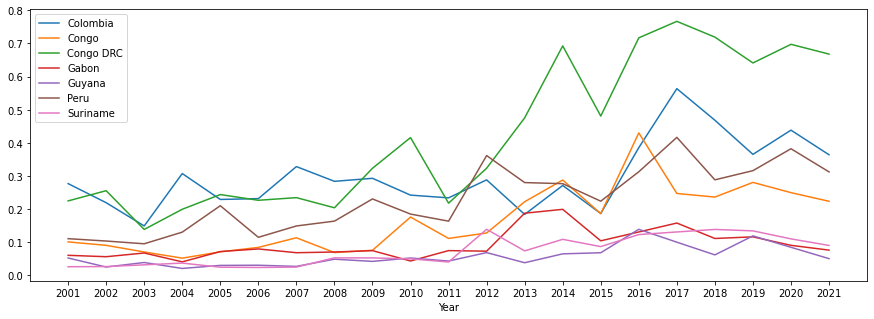

In [11]:
main = pd.read_csv('../data/main.csv')

fig, ax = plt.subplots()
for key, grp in main.groupby(['Country']):
    ax = grp.plot(ax=ax, kind='line', x='Year', y='Annual Tree Cover Loss', label=key, figsize=(15,5), xticks = [2000 + x for x in range(1,22)])

/tmp/ipykernel_552078/2382707037.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for key, grp in main.groupby(['Country']):


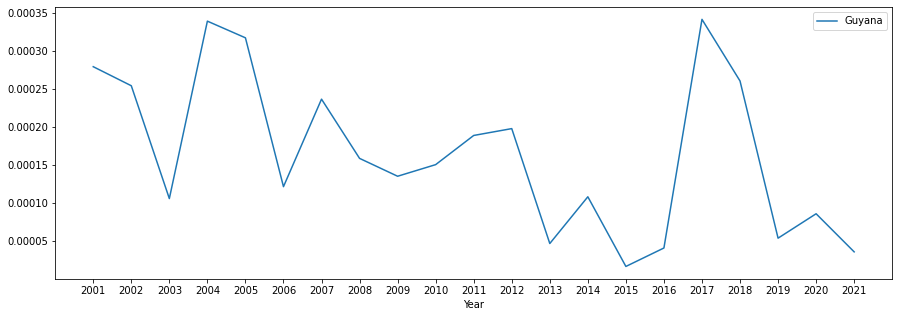

In [28]:
main = pd.read_csv('../data/main_cover.csv')

fig, ax = plt.subplots()
for key, grp in main.groupby(['Country']):
    ax = grp.plot(ax=ax, kind='line', x='Year', y='Annual Tree Cover Loss', label=key, figsize=(15,5), xticks = [2000 + x for x in range(1,22)])

In [24]:
main = pd.read_csv('../data/main_cover.csv')


In [25]:
main

,0,Guyana,2001,0.0002794544171827232,25513.9287
0,1,Guyana,2002,0.000254,25513.8638
1,2,Guyana,2003,0.000106,25513.8368
2,3,Guyana,2004,0.000339,25513.7502
3,4,Guyana,2005,0.000317,25513.6692
4,5,Guyana,2006,0.000122,25513.6382
5,6,Guyana,2007,0.000237,25513.5778
6,7,Guyana,2008,0.000159,25513.5373
7,8,Guyana,2009,0.000135,25513.5028
8,9,Guyana,2010,0.000151,25513.4644
9,10,Guyana,2011,0.000189,25513.4162


In [23]:
main

,0,Guyana,2001,0.0002794544171827232,25513.9287
0,1,Guyana,2002,0.000254,25513.8638
1,2,Guyana,2003,0.000106,25513.8368
2,3,Guyana,2004,0.000339,25513.7502
3,4,Guyana,2005,0.000317,25513.6692
4,5,Guyana,2006,0.000122,25513.6382
5,6,Guyana,2007,0.000237,25513.5778
6,7,Guyana,2008,0.000159,25513.5373
7,8,Guyana,2009,0.000135,25513.5028
8,9,Guyana,2010,0.000151,25513.4644
9,10,Guyana,2011,0.000189,25513.4162


In [9]:
def rebin(a, shape):
    '''
    Resizes a numpy array to the desired shape.
    '''
    sh = shape[0], a.shape[0]//shape[0], shape[1], a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)


def point_within_country(row, country_shp):
    '''
    Checks if the entered latitude and longitude are within the country of
    interest.
    '''
    point = Point(row['lon'], row['lat'])
    return country_shp.contains(point)


def sum_tile(tile, country_shp, topleftlat, topleftlon, canopy_threshold):
    '''
    Calculates total forest pixels and country pixels within the tile provided.

    Forest pixels are considered as those where canopy cover is greater than 
    or equal to the provided threshold. Typically, this is 30%.
    '''
    n = len(tile)

    tile_df = pd.DataFrame({'x': n * [x for x in range(n)],
                            'y': np.array([n * [y] for y in range(n)]).flatten()})

    tile_df['lat'] = topleftlat - (tile_df['y']/n) * 10
    tile_df['lon'] = topleftlon + (tile_df['x']/n) * 10

    tile_df['cover'] = tile.flatten()

    tile_df['country'] = tile_df.apply(
        point_within_country, axis=1, args=(country_shp,))

    forest_pixels = len(tile_df[(tile_df["country"] == True) & (
        tile_df["cover"] >= canopy_threshold)])
    country_pixels = len(tile_df[tile_df["country"] == True])

    return [forest_pixels, country_pixels, tile_df]


def sum_across_tiles(tiles, country_shp, topleftlats, topleftlons, canopy_threshold):
    '''
    Calculates total forest pixels and country pixels contained within the
    provided tiles. It is important to ensure that all tiles spanning the 
    country are provided.
    '''
    forest_total = 0
    country_total = 0
    tile_dfs = []
    for i, tile in enumerate(tiles):
        summary = sum_tile(tile, country_shp,
                           topleftlats[i], topleftlons[i], canopy_threshold)
        forest_total += summary[0]
        country_total += summary[1]
        tile_dfs.append(summary[2])
    return [forest_total, country_total, tile_dfs]


def cover_trajectory(forest_total, tile_dfs, loss_tiles):
    '''
    Given outputs of sum_across_tiles as well as loss_tiles, this provides the
    full annual forest loss trajectory for the dataset. 

    This function currently assumes that forest loss was calculated at the
    full 40,000 x 40,000 grid level, while the initial forest cover was only
    calculated at a 4,000 x 4,000 grid level. This would result in a 100 factor
    difference within the values obtained, which is accounted for here. 
    '''

    trajectory = dict()

    for i, df in enumerate(tile_dfs):

        df = df[df['country'] == True]
        df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()
                      for (x, y) in zip(df['x'], df['y'])]

        unique, counts = np.unique(df['loss'].explode(), return_counts=True)
        tile_trajectory = dict(zip(unique, counts))
        trajectory = {key: trajectory.get(key, 0) + tile_trajectory.get(key, 0)
                      for key in set(trajectory) | set(tile_trajectory)}

    annual_loss = []
    annual_cover = []

    for year in range(1, max(trajectory.keys()) + 1):
        # This is a percentage without multiplying by 100, since loss is at a 100 times higher resolution
        cover_loss = trajectory[year]/forest_total
        forest_total -= trajectory[year]/100
        annual_loss.append(cover_loss)
        annual_cover.append(forest_total)

    return [annual_loss, annual_cover]


def generate_trajectory(country, tiles, loss_tiles,
                        topleftlats, topleftlons, canopy_threshold):
    '''
    Aggregates the process for generating a time series of annual forest loss.
    '''

    boundaries = gpd.read_file("../data/World_Countries__Generalized_.shp")
    country_shp = boundaries[boundaries['COUNTRY'] == country].geometry

    for i, tile in enumerate(tiles):
        tiles[i] = rebin(np.array(tile), [4000, 4000])

    for i, tile in enumerate(loss_tiles):
        loss_tiles[i] = np.array(tile)

    country_sum = sum_across_tiles(tiles, country_shp, topleftlats,
                                   topleftlons, canopy_threshold)

    time_series = cover_trajectory(country_sum[0], country_sum[2], loss_tiles)

    output = pd.DataFrame({'Country': country,
                           'Year': [x for x in range(2001, 2022)],
                           'Annual Tree Cover Loss': time_series[0],
                           'Forest Cover': time_series[1]})

    output.to_csv('../data/main_cover.csv', mode='a', header=False)

    return output

In [99]:
country = 'Gabon'
canopy_threshold = 30

boundaries = gpd.read_file("../data/World_Countries__Generalized_.shp")
country_shp = boundaries[boundaries['COUNTRY'] == country].geometry

In [91]:
im10_60 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_060W.tif")
im10_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_070W.tif")
loss10_60 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_060W.tif")
loss10_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_070W.tif")

In [98]:
im00_00 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_000E.tif")
im00_10 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_010E.tif")
im10_00 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_000E.tif")
im10_10 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_010E.tif")
loss00_00 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_000E.tif")
loss00_10 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_010E.tif")
loss10_00 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_000E.tif")
loss10_10 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_010E.tif")

In [92]:
im10_60 = rebin(np.array(im10_60), [4000, 4000])
im10_70 = rebin(np.array(im10_70), [4000, 4000])
loss10_60 = np.array(loss10_60)
loss10_70 = np.array(loss10_70)

In [100]:
im00_00 = rebin(np.array(im00_00), [4000, 4000])
im00_10 = rebin(np.array(im00_10), [4000, 4000])
im10_00 = rebin(np.array(im10_00), [4000, 4000])
im10_10 = rebin(np.array(im10_10), [4000, 4000])
loss00_00 = np.array(loss00_00)
loss00_10 = np.array(loss00_10)
loss10_00 = np.array(loss10_00)
loss10_10 = np.array(loss10_10)

In [116]:
n = 100
topleftlat = 10
topleftlon = 10
tile = im10_10
loss_tile = loss10_10

tile_df = pd.DataFrame({'x': n * [x for x in range(n)],
                            'y': np.array([n * [y] for y in range(n)]).flatten()})

tile_df['lat'] = topleftlat - (tile_df['y']/n) * 10
tile_df['lon'] = topleftlon + (tile_df['x']/n) * 10

In [117]:
tile_df['country'] = tile_df.apply(
    point_within_country, axis=1, args=(country_shp,))

In [118]:
res = len(tile)
u = int(res / n)

df = tile_df

df = df[df['country'] == True]

df['cover'] = [tile[(y * u):(y * u + u), (x * u):(x * u + u)].flatten()
                      for (x, y) in zip(df['x'], df['y'])]

/tmp/ipykernel_1136086/459576870.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cover'] = [tile[(y * u):(y * u + u), (x * u):(x * u + u)].flatten()


In [119]:
u = int(len(loss_tile) / n)

df['loss'] = [loss_tile[(y * u):(y * u + u), (x * u):(x * u + u)].flatten()
                      for (x, y) in zip(df['x'], df['y'])]

/tmp/ipykernel_1136086/3555801016.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tile[(y * u):(y * u + u), (x * u):(x * u + u)].flatten()


In [70]:
import os

In [72]:
def unit_trajectory(row, country, status):    

    forest = sum(row['cover'] > 30)
    trajectory = dict()

    unique, counts = np.unique(row['loss'], return_counts=True)
    tile_trajectory = dict(zip(unique, counts))
    trajectory = {key: trajectory.get(key, 0) + tile_trajectory.get(key, 0)
                    for key in range(1, 22)}

    annual_loss = []

    for year in range(1, max(trajectory.keys()) + 1):
        # This is a percentage without multiplying by 100, since loss is at a 100 times higher resolution
        cover_loss = trajectory[year]/forest
        forest -= trajectory[year]/100
        annual_loss.append(cover_loss)

    output = pd.DataFrame({'Country': country,
                           'Latitude': row['lat'],
                           'Longitude': row['lon'],
                           'Year': [x for x in range(2001, 2022)],
                           'Annual Tree Cover Loss': annual_loss,
                           'Status': status})
    
    output_path = '../data/main_unit.csv'
    output.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
    

In [120]:
df.apply(unit_trajectory, axis=1, args=(country,'Untreated'))

7714    None
7715    None
7716    None
7717    None
7723    None
        ... 
9935    None
9936    None
9937    None
9938    None
9939    None
Length: 682, dtype: object